# Generating Airfoils from Data-Driven Domains

**Input to define domain**:

- Saved PGA spaces or dataset of 2D shapes (cross sections) with consistent landmarks both in number and reparametrization---i.e., each discrete shape is represented by the same number of landmarks generated by a consistent CST-cosine reparametrization over the shape

- Dependencies detailed below

In [1]:
# Python
import os
import numpy as np
# G2Aero
from g2aero.PGA import PGAspace
from g2aero import SPD
from g2aero import Grassmann as gr
#Plotting
import matplotlib.pyplot as plt
%matplotlib inline

## Read PGA space from saved domain
Reusing the data consistent with the previous notebook [Data-Driven Domain of Shapes](https://g2aero.readthedocs.io/en/latest/how_to_guides/files/0_Data-Driven_Domain.html#), we begin by loading a PGA space from our .npz files saved in `data/pga_space/`.

In [2]:
# load Karcher mean and PGA basis
pga = PGAspace.load_from_file(os.path.join(os.getcwd(), '../../data/pga_space/CST_Gr_PGA.npz'))
print("Grassmann Dataset:")
print(f"Shape of data = {pga.t.shape[0]}-by-{pga.t.shape[1]}")
print(f"Number of shapes = {pga.t.shape[0]}")
print(f"Number of coordinates = {pga.t.shape[1]}")
print('\n')

# load SPD PGA statistics
spd_dict = np.load(os.path.join(os.getcwd(), '../../data/pga_space/CST_SPD_PGA.npz'))
ell = spd_dict['coords']
P0 = spd_dict['karcher_mean']
P = spd_dict['data']
print("SPD Dataset:")
print(f"Shape of data = {P.shape}")
print(f"Number of SPD matrices = {P.shape[0]}")
print(f"Shape of coordinates = {ell.shape}")

Grassmann Dataset:
Shape of data = 13000-by-798
Number of shapes = 13000
Number of coordinates = 798


SPD Dataset:
Shape of data = (13000, 2, 2)
Number of SPD matrices = 13000
Shape of coordinates = (13000, 3)


## Example random shape generation
We outline a simple manual approach to generate new random shapes over the dominate eigenspaces of Grassmann normal coordinate covariance and two choices of avearge scale. However, more sophisticated approaches to sampling are conceivable. As such, we also highlight the use of an automated routine to generate random shapes from a uniform ball of normal coordinates subject to a self-intersection constraint. We demonstrate how shapes with any prescribed coordinates can be replicated using our automated routine by assigning `coef`. 

Note: "warnings" are issued by the automated routine when a shape intersects itself. A new random `coef` is subsequently drawn to replace the corresponding index until the the shape is non-intersecting.

In [3]:
np.random.default_rng(seed=42)
# assign r as the dimension of the PGA shape
r = 4 # should always be less than or equal to 2*(n_landmarks - 2)
pga.t = pga.t[:,:r]

# compute eigenspaces of covariances over Gr(n,2) coordinates
Lambda_t, W_t = np.linalg.eigh(1/np.sqrt(pga.t.shape[0]-1)*( pga.t.T @ pga.t))

# sample a random coordinate with reduce variation to protect against self-intersection
rnd_t = (W_t @ np.diag(Lambda_t)) @ np.random.normal(0,0.25,size=(r,1))

# use the random coordinates and intrinsic mean of SPD matrices to sample a random shape
rnd_shape = pga.PGA2shape(rnd_t.flatten(),M=P0,b=pga.b_mean)
# or generate the random shape with an extrinsic-average scale
rnd_shape_avg = pga.PGA2shape(rnd_t.T,M=pga.M_mean,b=pga.b_mean)

# the process of generating a random shape with extrinsic average scale is also automated using:
rnd_shape_auto, _, _ = pga.generate_perturbed_shapes(coef=rnd_t.T,n=1)
# we can also use this routine to generate as many non-intersecting r-dim. shapes as desired by setting `n':
# in this case n=10 samples and we utilize the full-dimension expansion (r=18)
rnd_shapes, _, rnd_coef = pga.generate_perturbed_shapes(n=10,n_modes=18)
print('\n')
print('Random data:')
print(f'Random shapes shape: {rnd_shapes.shape}')
print(f'Random coord. shape: {rnd_coef.shape}')



Random data:
Random shapes shape: (10, 401, 2)
Random coord. shape: (10, 18)


Then we plot our three randomly generated shapes to compare them visually. The shape generated by our automated routine is given consistent coordinates as the avgerage scale shape, thus those two shapes overlap in the plot. Notice that the extrinsic average scale is slightly "inflated" beyond the intrinsic average.

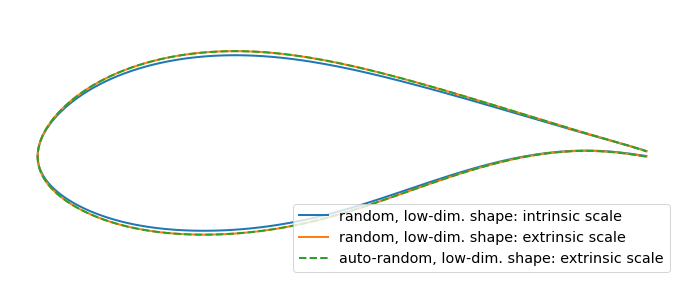

In [4]:
# plot the random shape with different scale
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.plot(rnd_shape[:,0], rnd_shape[:,1],linewidth=2, label='random, low-dim. shape: intrinsic scale')
plt.plot(rnd_shape_avg[:,0], rnd_shape_avg[:,1],linewidth=2, label='random, low-dim. shape: extrinsic scale')
plt.plot(rnd_shape_auto[:,0],rnd_shape_auto[:,1],'--',linewidth=2, label='auto-random, low-dim. shape: extrinsic scale')
# formatting
plt.axis('off')
ax.axis('equal')
ax.legend(fontsize='x-large')

Let's also plot a smattering of our randomly generated shapes and compare them to consistent low-dimension analogues. In other words, we reduce the coordinate expansion for the full-dimensional shapes down to 2, 4, 8, and 16 then overlay the low-dimensional expansions of the shape along a consistent subset of coordinates. (lower dimensional planar sections of the Grassmanian) Notice that with increasing dimension we can capture more undulation in the shape and the 8 and 16-dimensional shapes are nearly visually indistinguishable from the full-dimensional shape while the 2 and 4-dimensional shapes are regularized to have fewer inflections.

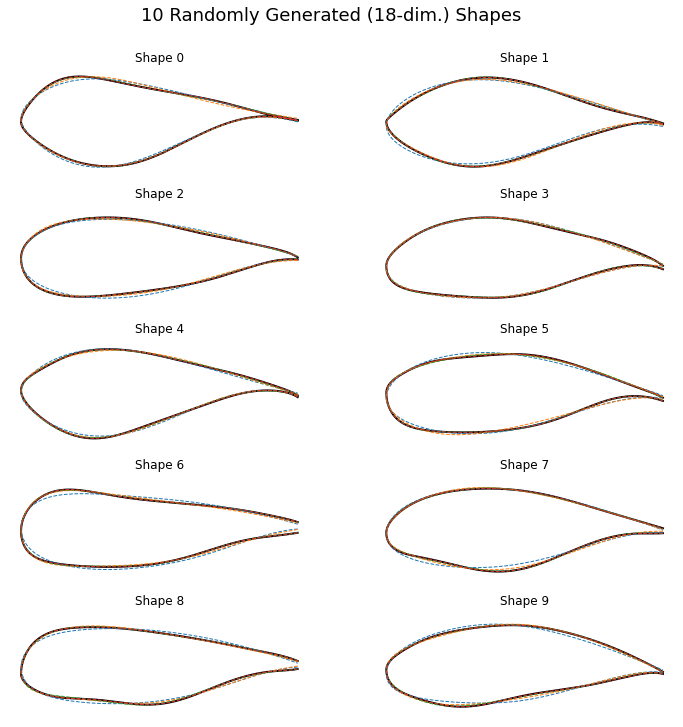

In [5]:
# plot automatically generated random shapes
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.25)
plt.suptitle(f"{10} Randomly Generated ({18}-dim.) Shapes", fontsize=18, y=0.95)

dims = [2,4,8,16]
# loop through the length of shapes
for i, shape in enumerate(rnd_shapes):
    # add a new subplot iteratively
    ax = plt.subplot(5, 2, i + 1)
    
    # plot the random shape
    plt.plot(shape[:,0],shape[:,1],'k',linewidth=2)
    # loop through low-dimension analouges
    for dim in dims:
        shape_low = pga.PGA2shape(rnd_coef[i,:dim],M=pga.M_mean,b=pga.b_mean)
        plt.plot(shape_low[:,0],shape_low[:,1],'--',linewidth=1)
        

    # chart formatting
    ax.set_title(f'Shape {i}')
    ax.set_xlabel("")
    ax.axis('off')
    ax.axis('equal')

Zooming in on one of the random shapes, we can see the visual consistency between shapes despite the dramatic reduction in dimensionality. (similar to the previous notebook: [Data-Driven Domain of Shapes](https://g2aero.readthedocs.io/en/latest/how_to_guides/files/0_Data-Driven_Domain.html#)) 

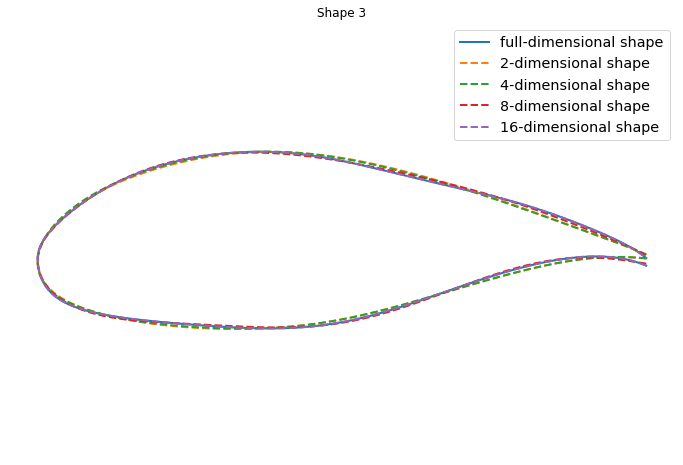

In [6]:
# pick a random index to more closely inspect
rnd_i = 3

# plot the random shape with different scale
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plt.plot(rnd_shapes[rnd_i,:,0], rnd_shapes[rnd_i,:,1],linewidth=2, label='full-dimensional shape')
# loop through low-dimension analouges
for dim in dims:
    shape_low = pga.PGA2shape(rnd_coef[rnd_i,:dim],M=pga.M_mean,b=pga.b_mean)
    plt.plot(shape_low[:,0],shape_low[:,1],'--',linewidth=2,label=str(dim)+"-dimensional shape")
# formatting
ax.set_title(f'Shape {rnd_i}')
plt.axis('off')
ax.axis('equal')
ax.legend(fontsize='x-large')